In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.utils import tight_bbox, parse_lipid
from src.plots import plot_quant_vs_ogtt, set_square_ratio

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks'

import importlib
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from statsmodels.api import formula as smf

In [13]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

vldata = pd.read_csv('../data/processed/1700s_validation_lipids.csv', index_col=0)
vldata_cols = fg.loc[(fg['cohort'] == '30wk') & fg['has_ogtt']].index
qc_rep_1700s = fg.loc[fg['qc_rep']].index

## Mixed effects modeling

In [8]:
vldata

,RT,m/z,polarity,ID,molec_class,Features Found,1700s_extract_blank_rep1,1700s_extract_blank_rep2,1700s_extract_blank_rep3,1700s_QCdil_025,...,1748_30_RBG,1748_31_RBG,1754_30_RBG,1754_31_RBG,1754_32_RBG,qc_rsd,qc_dil_mse,is_monotonic,is_id,superclass
vl_6,0.703,287.05676,+,Unidentified,Unidentified,51,13.891960,13.875591,13.951897,23.224394,...,23.833446,23.860861,24.561615,24.819140,24.342488,13.126279,0.202596,True,False,Unidentified
vl_11,0.706,247.09293,-,Unidentified,Unidentified,53,14.076268,14.972670,14.172502,23.709329,...,24.462188,25.056897,25.395430,26.080585,25.063374,12.402181,0.070669,True,False,Unidentified
vl_16,0.709,426.99759,-,Unidentified,Unidentified,19,13.754865,13.734585,13.909297,23.134954,...,24.395736,24.285635,24.550059,25.129216,24.762444,11.069221,0.188036,True,False,Unidentified
vl_19,0.715,293.09964,+,Unidentified,Unidentified,79,14.587984,15.851096,17.730969,27.486901,...,29.541390,28.858724,29.724615,30.303536,29.635534,11.255436,0.025387,True,False,Unidentified
vl_60,0.762,514.28418,-,Unidentified,Unidentified,22,17.274716,17.585457,17.806500,21.184131,...,22.259845,23.801439,23.230814,21.760463,22.551999,10.966872,0.221499,True,False,Unidentified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vl_6458,20.537,986.92023,+,TG 18:2_18:1_24:0,TG,78,17.113679,17.271889,17.956024,21.115378,...,23.189039,24.341628,23.049654,21.112887,22.252479,14.653994,0.016109,True,True,Glycerolipid
vl_6461,20.542,965.86005,+,TG 58:2,TG,147,19.850663,19.817206,19.797762,22.215077,...,23.771806,24.981126,23.913712,22.333982,22.930080,10.214240,0.058626,True,True,Glycerolipid
vl_6481,20.802,897.83301,+,Unidentified,Unidentified,75,16.737103,16.654132,16.701457,21.689973,...,24.817736,24.828439,25.010471,21.869211,22.639417,12.288005,0.004663,True,False,Unidentified
vl_6484,20.813,593.59186,+,Unidentified,Unidentified,70,16.918875,16.876138,16.883230,20.279748,...,23.501130,23.491587,23.665170,20.632481,21.319745,9.932066,0.005341,True,False,Unidentified


In [15]:
fg

,animal,sex,cohort,sufficient_sample,litter,gluc_tol,bg_type,OGTT_week,week,num_wk_before_ogtt,...,lipidex_file_number,date,File Name_metab,metab_run_order,fixed_filename,qc_rep,qc_dilution,blank_file,quant_file,lipid_run_order
1091_8_FBG,1091,M,10wk,True,2.0,normal,FBG,12.0,8.0,4.0,...,35.0,3/27/2021,20210831_KAO_HILIC_T1091M_20210327_8wk_FBG,63.0,20210831_KAO_HILIC_T1091M_20210327_8wk_FBG,False,False,False,True,56
1091_9_FBG,1091,M,10wk,True,2.0,normal,FBG,12.0,9.0,3.0,...,37.0,4/2/2021,20210831_KAO_HILIC_T1091M_20210402_9wk_FBG,29.0,20210831_KAO_HILIC_T1091M_20210402_9wk_FBG,False,False,False,True,46
1091_10_FBG,1091,M,10wk,True,2.0,normal,FBG,12.0,10.0,2.0,...,39.0,4/10/2021,20210831_KAO_HILIC_T1091M_20210410_10wk_FBG,56.0,20210831_KAO_HILIC_T1091M_20210410_10wk_FBG,False,False,False,True,11
1093_8_FBG,1093,M,10wk,True,2.0,normal,FBG,12.0,8.0,4.0,...,47.0,3/27/2021,20210831_KAO_HILIC_T1093M_20210327_8wk_FBG,32.0,20210831_KAO_HILIC_T1093M_20210327_8wk_FBG,False,False,False,True,34
1093_9_FBG,1093,M,10wk,True,2.0,normal,FBG,12.0,9.0,3.0,...,49.0,4/2/2021,20210831_KAO_HILIC_T1093M_20210402_9wk_FBG,50.0,20210831_KAO_HILIC_T1093M_20210402_9wk_FBG,False,False,False,True,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700s_QCdil_200,dil,NaN,30wk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,True,False,False,58
1700s_resuspension_blank_rep1,resus_blank,NaN,30wk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,True,False,3
1700s_resuspension_blank_rep2,resus_blank,NaN,30wk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,True,False,60
1700s_water_blank_rep1,water,NaN,30wk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,True,False,1


In [41]:
models = {}
for i, feature in enumerate(vldata.index):
#     if i == 20:
#         break
    print(feature)
    df = (vldata
          .loc[:, vldata_cols]
          .T
          .join(fg[['animal', 'sex', 'ogtt', 'num_wk_before_ogtt']])
         )
    id_ = vldata.loc[feature, 'ID']
    if 'd-' in id_:
        continue
    model = smf.mixedlm(
        f'{feature} ~ ogtt + sex + ogtt:sex', 
        data=df, groups='animal', #vc_formula={'sex': '0 + C(sex)'},
    )
    model = model.fit(maxiter=10)
    models[feature] = model

vl_6
vl_11
vl_16
vl_19
vl_60
vl_84
vl_131
vl_217
vl_242
vl_243
vl_250
vl_257
vl_258
vl_278


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_294
vl_314
vl_317


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_323


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_333


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_336
vl_350
vl_357
vl_362


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_396


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_398
vl_400


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_405
vl_411
vl_420
vl_421
vl_444


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_453
vl_454
vl_456
vl_458


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_468
vl_480
vl_482
vl_490
vl_495
vl_499


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_518
vl_520
vl_530
vl_531


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_561
vl_711
vl_783
vl_793
vl_828
vl_830
vl_832
vl_835
vl_880
vl_891
vl_893
vl_894
vl_895
vl_897
vl_898


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_900
vl_903
vl_905
vl_906


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


vl_910
vl_913
vl_921
vl_922
vl_923
vl_924
vl_926
vl_928
vl_946
vl_948
vl_952
vl_953
vl_956
vl_959
vl_988
vl_1027
vl_1046
vl_1048
vl_1051


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_1052
vl_1054
vl_1056
vl_1060
vl_1061
vl_1069
vl_1073
vl_1075
vl_1082
vl_1088
vl_1094
vl_1123
vl_1128


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261

vl_1134
vl_1139
vl_1141
vl_1143
vl_1144
vl_1154


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_1157
vl_1188
vl_1189
vl_1192
vl_1193
vl_1200
vl_1202
vl_1206
vl_1219
vl_1235
vl_1236
vl_1238
vl_1241
vl_1243
vl_1245


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_1256
vl_1258
vl_1259
vl_1262


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_1263
vl_1264
vl_1276
vl_1290
vl_1293
vl_1299
vl_1303
vl_1314
vl_1316
vl_1318
vl_1320
vl_1321
vl_1324


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_1340
vl_1345
vl_1346
vl_1348
vl_1388
vl_1417
vl_1428
vl_1429
vl_1430
vl_1432
vl_1433
vl_1435
vl_1438
vl_1461
vl_1463
vl_1466


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_1491
vl_1496
vl_1497
vl_1499
vl_1502
vl_1503


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_1508
vl_1514
vl_1520
vl_1522
vl_1535
vl_1536
vl_1539
vl_1550


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_1567
vl_1569
vl_1571
vl_1575
vl_1576
vl_1586
vl_1620
vl_1641
vl_1695
vl_1722
vl_1724
vl_1729
vl_1731
vl_1791
vl_1796
vl_1797
vl_1808
vl_1814
vl_1815
vl_1824
vl_1842
vl_1844
vl_1848
vl_1854
vl_1889
vl_1891
vl_1892
vl_1914
vl_1921
vl_1937
vl_1942
vl_1952
vl_1974
vl_1977
vl_1982
vl_1985
vl_2007
vl_2018
vl_2021
vl_2027
vl_2039
vl_2069


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2070
vl_2078
vl_2079
vl_2085


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2095
vl_2099
vl_2110
vl_2119
vl_2122
vl_2139


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_2140
vl_2143
vl_2146
vl_2147
vl_2148
vl_2152


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


vl_2155
vl_2156
vl_2167
vl_2178
vl_2179
vl_2180
vl_2181
vl_2183
vl_2186
vl_2188
vl_2194
vl_2196
vl_2198
vl_2202
vl_2206
vl_2207
vl_2225
vl_2239
vl_2240
vl_2249
vl_2273
vl_2276


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_2287
vl_2305
vl_2306
vl_2319
vl_2327
vl_2330
vl_2331
vl_2336
vl_2337
vl_2339
vl_2340
vl_2341


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2357
vl_2360
vl_2361
vl_2375
vl_2379
vl_2384
vl_2388
vl_2390
vl_2392
vl_2393
vl_2395
vl_2405
vl_2432
vl_2440


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2447
vl_2451
vl_2454


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2456
vl_2463
vl_2465


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2467
vl_2468
vl_2469


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2470
vl_2473
vl_2479
vl_2483
vl_2493
vl_2500
vl_2527
vl_2533
vl_2534


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_2535
vl_2537
vl_2539
vl_2549
vl_2550
vl_2552
vl_2553
vl_2555
vl_2556
vl_2559
vl_2561
vl_2566
vl_2570
vl_2579
vl_2582
vl_2588
vl_2593
vl_2594
vl_2595


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_2597
vl_2598
vl_2603
vl_2610
vl_2614
vl_2616
vl_2617
vl_2619
vl_2624
vl_2633
vl_2634
vl_2635
vl_2636


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2639
vl_2641
vl_2642
vl_2643
vl_2645
vl_2649


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


vl_2651
vl_2652
vl_2653
vl_2654
vl_2655
vl_2656
vl_2658
vl_2661
vl_2665
vl_2667
vl_2671
vl_2676
vl_2687
vl_2704


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2708
vl_2713
vl_2715
vl_2721
vl_2722
vl_2723
vl_2724
vl_2731
vl_2732
vl_2735
vl_2738
vl_2744
vl_2754
vl_2756
vl_2762
vl_2764
vl_2765
vl_2778
vl_2792
vl_2798
vl_2800
vl_2801
vl_2808
vl_2813
vl_2817


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2820
vl_2823
vl_2831
vl_2840
vl_2848
vl_2851
vl_2860
vl_2861
vl_2862
vl_2864
vl_2876
vl_2878
vl_2888
vl_2895


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


vl_2902
vl_2906
vl_2911
vl_2912
vl_2915


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


vl_2917
vl_2919
vl_2920
vl_2921
vl_2932
vl_2950
vl_2951


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_2953
vl_2955
vl_2971
vl_2976
vl_2979
vl_2981
vl_2982
vl_2984
vl_2985
vl_2988
vl_2998


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_3004
vl_3007
vl_3013
vl_3032
vl_3035
vl_3043
vl_3044
vl_3045
vl_3046
vl_3050
vl_3055
vl_3061
vl_3067


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_3068
vl_3072
vl_3073
vl_3074
vl_3077
vl_3079
vl_3085
vl_3095
vl_3096
vl_3103
vl_3104
vl_3109


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_3110
vl_3112
vl_3119
vl_3145


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_3151
vl_3153
vl_3154
vl_3155


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_3156
vl_3167
vl_3170
vl_3175
vl_3178
vl_3179
vl_3196
vl_3203
vl_3207


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


vl_3212
vl_3213
vl_3217


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_3237
vl_3251
vl_3258


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_3278
vl_3285
vl_3287
vl_3288
vl_3300
vl_3303
vl_3306
vl_3316
vl_3330
vl_3342
vl_3355
vl_3378
vl_3379
vl_3380


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_3385
vl_3388
vl_3389
vl_3421
vl_3444
vl_3461


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_3467
vl_3480
vl_3484
vl_3499
vl_3502
vl_3504
vl_3507
vl_3510
vl_3513
vl_3517
vl_3520
vl_3523
vl_3529
vl_3531


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_3536
vl_3549
vl_3552


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_3562
vl_3572
vl_3586
vl_3595
vl_3602
vl_3604
vl_3606
vl_3610
vl_3618
vl_3619
vl_3626


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_3631
vl_3633
vl_3642
vl_3644
vl_3648
vl_3658
vl_3662
vl_3673


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


vl_3681
vl_3683
vl_3684
vl_3685
vl_3697
vl_3710
vl_3721
vl_3724
vl_3728
vl_3729
vl_3730
vl_3734
vl_3737
vl_3744
vl_3745
vl_3748
vl_3752
vl_3755
vl_3756
vl_3757
vl_3758
vl_3760
vl_3761
vl_3762
vl_3763
vl_3765
vl_3767
vl_3769
vl_3770
vl_3775
vl_3778
vl_3779
vl_3780
vl_3791
vl_3801


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_3802
vl_3805
vl_3814
vl_3818
vl_3820
vl_3823
vl_3831
vl_3840
vl_3846
vl_3877
vl_3881
vl_3882
vl_3889
vl_3895
vl_3897
vl_3901
vl_3902
vl_3912


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_3938
vl_3940
vl_3945
vl_3950
vl_3968
vl_3972
vl_3977
vl_3992
vl_3994
vl_4000
vl_4002
vl_4003
vl_4004
vl_4005
vl_4012
vl_4017
vl_4035
vl_4037
vl_4051
vl_4057
vl_4070
vl_4074
vl_4096
vl_4126
vl_4127
vl_4128
vl_4129
vl_4130
vl_4131
vl_4132
vl_4133
vl_4134
vl_4135
vl_4136
vl_4137
vl_4138
vl_4140
vl_4142
vl_4145
vl_4161
vl_4176
vl_4178
vl_4184
vl_4185
vl_4186
vl_4187
vl_4188
vl_4191
vl_4192
vl_4193
vl_4195
vl_4196
vl_4197
vl_4207
vl_4213
vl_4214
vl_4218
vl_4220
vl_4252
vl_4273
vl_4274
vl_4275
vl_4279
vl_4280
vl_4288
vl_4304
vl_4314
vl_4340
vl_4341
vl_4342
vl_4343
vl_4345
vl_4346
vl_4347
vl_4349
vl_4350
vl_4351
vl_4353
vl_4354
vl_4356
vl_4357
vl_4358
vl_4361
vl_4373
vl_4381
vl_4382
vl_4396
vl_4416
vl_4417
vl_4454
vl_4456
vl_4462
vl_4474
vl_4508
vl_4513
vl_4515
vl_4520
vl_4542
vl_4544


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_4545
vl_4547
vl_4548
vl_4550
vl_4551
vl_4552
vl_4554
vl_4555
vl_4556
vl_4557
vl_4558
vl_4576
vl_4578
vl_4591
vl_4608
vl_4609
vl_4611
vl_4629
vl_4630
vl_4631
vl_4632
vl_4655
vl_4656
vl_4657
vl_4690
vl_4719
vl_4720
vl_4733
vl_4741
vl_4745
vl_4768
vl_4769
vl_4771
vl_4772
vl_4784
vl_4786
vl_4814
vl_4838
vl_4862
vl_4872
vl_4877
vl_4879
vl_4902
vl_4903
vl_4904
vl_4905
vl_4907
vl_4912
vl_4920
vl_4921
vl_4931
vl_4939


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

vl_4968
vl_4969
vl_4970
vl_4971
vl_4972
vl_4973
vl_4974
vl_5000
vl_5015
vl_5024
vl_5025
vl_5071
vl_5078
vl_5085
vl_5097
vl_5100
vl_5101
vl_5102
vl_5103
vl_5104
vl_5115
vl_5116
vl_5118
vl_5119
vl_5124
vl_5130
vl_5143
vl_5154
vl_5156
vl_5161
vl_5162
vl_5163
vl_5164
vl_5165
vl_5174
vl_5177
vl_5179
vl_5182
vl_5187
vl_5196
vl_5197
vl_5202
vl_5204
vl_5208


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_5222
vl_5224
vl_5226
vl_5240
vl_5244
vl_5260
vl_5265
vl_5280
vl_5282
vl_5290
vl_5337
vl_5342
vl_5345
vl_5347
vl_5354
vl_5356
vl_5357
vl_5360
vl_5361
vl_5369
vl_5370
vl_5371
vl_5377
vl_5379
vl_5381
vl_5383
vl_5387
vl_5391
vl_5394
vl_5395
vl_5405
vl_5407
vl_5409
vl_5414
vl_5421
vl_5428
vl_5436
vl_5437
vl_5440
vl_5441
vl_5443
vl_5444
vl_5448
vl_5449
vl_5471
vl_5484
vl_5485
vl_5491
vl_5492
vl_5493
vl_5498
vl_5506


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_5510


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_5511
vl_5535
vl_5536
vl_5543
vl_5544
vl_5545
vl_5559
vl_5568
vl_5571
vl_5572
vl_5574
vl_5576
vl_5583
vl_5587
vl_5595
vl_5596
vl_5603
vl_5613
vl_5615
vl_5616
vl_5620
vl_5621
vl_5622
vl_5630
vl_5637
vl_5641
vl_5642
vl_5644
vl_5645
vl_5697
vl_5698
vl_5699
vl_5706
vl_5716
vl_5718
vl_5720
vl_5729
vl_5735


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_5736
vl_5741
vl_5746
vl_5748
vl_5775
vl_5799
vl_5804
vl_5809
vl_5818
vl_5821
vl_5822
vl_5828
vl_5829
vl_5830
vl_5837
vl_5839
vl_5856
vl_5874
vl_5878
vl_5879
vl_5883
vl_5884
vl_5885
vl_5888
vl_5892
vl_5893
vl_5897
vl_5904
vl_5912
vl_5918
vl_5935
vl_5956
vl_5958
vl_5965
vl_5984
vl_5993
vl_6006


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


vl_6010
vl_6018
vl_6022
vl_6043
vl_6057
vl_6058
vl_6059
vl_6060
vl_6063
vl_6068
vl_6071
vl_6074
vl_6108
vl_6126
vl_6155
vl_6156
vl_6164
vl_6173
vl_6182
vl_6183
vl_6191
vl_6199
vl_6200
vl_6202
vl_6226
vl_6228
vl_6235
vl_6258
vl_6268
vl_6269
vl_6270
vl_6271
vl_6274
vl_6282
vl_6283
vl_6284
vl_6285
vl_6289
vl_6290
vl_6291
vl_6297
vl_6322
vl_6325
vl_6327
vl_6330
vl_6334
vl_6336
vl_6339
vl_6340
vl_6342
vl_6343
vl_6356
vl_6359
vl_6379
vl_6390
vl_6391
vl_6392
vl_6395
vl_6396
vl_6420
vl_6422
vl_6425
vl_6429
vl_6430
vl_6431
vl_6433
vl_6434
vl_6435
vl_6436
vl_6454
vl_6457
vl_6458
vl_6461
vl_6481
vl_6484
vl_6490


In [55]:
r = []
for i, model in models.items():
    s = model.pvalues
    s.name = i
    r.append(s)
r = pd.DataFrame(r)

In [66]:
r.sort_values('sex[T.M]').join(vldata['ID']).iloc[:50]

,Intercept,sex[T.M],ogtt,ogtt:sex[T.M],animal Var,ID
vl_5202,0.000000e+00,0.000608,0.450654,0.001042,0.253042,Unidentified
vl_2341,6.184255e-294,0.001819,0.152159,0.007493,1.000000,Unidentified
vl_5204,2.935660e-219,0.002349,0.402505,0.003262,0.491584,Unidentified
vl_396,4.150070e-214,0.003965,0.002339,0.002195,0.999955,Unidentified
vl_4838,0.000000e+00,0.003997,0.861219,0.002415,0.512126,Unidentified
vl_400,1.897369e-215,0.009083,0.384329,0.013184,NaN,Unidentified
vl_4373,9.654769e-180,0.009851,0.680843,0.007869,0.249651,Unidentified
vl_5993,8.785160e-04,0.012332,0.008121,0.046503,0.113140,Unidentified
vl_4381,0.000000e+00,0.013799,0.384387,0.021616,0.459486,Unidentified
vl_3721,1.566402e-71,0.018735,0.550915,0.026375,0.156392,Unidentified


In [30]:
models['vl_294'].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: vl_294  
No. Observations: 33      Method:             REML    
No. Groups:       11      Scale:              0.0929  
Min. group size:  3       Log-Likelihood:     -36.6035
Max. group size:  3       Converged:          Yes     
Mean group size:  3.0                                 
------------------------------------------------------
             Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    16.532    2.476 6.678 0.000 11.680 21.384
ogtt          0.000    0.000 1.662 0.096 -0.000  0.000
sex Var       1.431    2.683                          
======================================================

"""

Text(0.5, 1.0, 'vl_4879\nTG 22:6_22:6_22:6\n14.281')

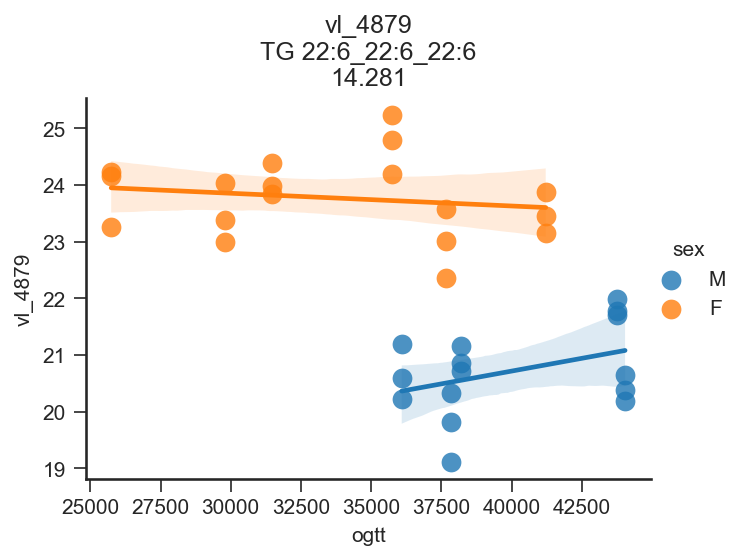

In [44]:
df = vldata.filter(regex='RBG').T.join(fg[['ogtt', 'sex']])
# feature = filt2.loc[filt2['is_id']].sample(1).index[0]  # random feature
feature = 'vl_4879'  # TG 22:6_22:6_22:6
# fig, ax = plt.subplots(dpi=150, figsize=(5, 3))
sns.lmplot(
    data=df, 
#     y='vl_6435',
    y=feature,
    x='ogtt',
    hue='sex', 
    scatter_kws=dict(lw=0, s=90)
)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(5, 3)
fig.set_dpi(150)
ax.set_title(f'{feature}\n{vldata.loc[feature, "ID"]}\n{vldata.loc[feature, "RT"]}')

In [113]:
vldata.loc[vldata['molec_class'] == 'TG']

,RT,m/z,polarity,ID,molec_class,Features Found,1700s_extract_blank_rep1,1700s_extract_blank_rep2,1700s_extract_blank_rep3,1700s_QCdil_025,...,1748_30_RBG,1748_31_RBG,1754_30_RBG,1754_31_RBG,1754_32_RBG,qc_rsd,qc_dil_mse,is_monotonic,is_id,superclass
vl_4879,14.281,1045.73621,+,TG 22:6_22:6_22:6,TG,72,15.816341,16.118842,15.859831,20.579060,...,23.019494,23.582527,23.986933,24.391858,23.843569,10.762955,0.060234,True,True,Glycerolipid
vl_4920,14.400,945.70306,+,TG 18:2_20:5_20:5,TG,107,17.483492,16.990532,17.634728,23.581445,...,25.885995,25.985697,26.179407,26.337664,25.443549,7.110776,0.040700,True,True,Glycerolipid
vl_5024,14.704,971.71759,+,TG 60:13,TG,116,16.288480,16.910392,16.436217,25.161513,...,27.448287,27.649109,27.913557,28.191626,27.416221,8.410783,0.050773,True,True,Glycerolipid
vl_5025,14.704,921.70087,+,TG 18:3_18:2_20:5,TG,47,16.364200,16.986111,16.511937,22.369451,...,24.561435,26.049846,24.723658,24.376875,23.832845,7.855389,0.077116,True,True,Glycerolipid
vl_5071,14.883,945.70154,+,TG 14:0_22:6_22:6,TG,43,15.946828,15.990494,16.117886,20.619869,...,22.563677,24.201516,23.209699,22.795723,23.039816,8.025936,0.075788,True,True,Glycerolipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vl_6431,20.242,977.86035,+,TG 18:2_18:1_23:0,TG,72,16.701427,16.705873,16.712249,20.035100,...,22.209044,23.560837,21.969226,20.216785,21.176014,13.275089,0.038417,True,True,Glycerolipid
vl_6436,20.265,946.88922,+,TG 57:2,TG,66,18.746826,17.733955,18.826365,20.656709,...,22.142564,23.412003,21.928645,20.012024,21.489149,7.259821,0.077896,True,True,Glycerolipid
vl_6454,20.508,934.88812,+,TG 56:1,TG,89,20.269431,20.744248,21.309080,22.776710,...,24.122174,25.282569,24.168322,22.014429,23.553789,13.725616,0.144476,True,True,Glycerolipid
vl_6458,20.537,986.92023,+,TG 18:2_18:1_24:0,TG,78,17.113679,17.271889,17.956024,21.115378,...,23.189039,24.341628,23.049654,21.112887,22.252479,14.653994,0.016109,True,True,Glycerolipid


In [118]:
vldata.loc[vldata['is_id']].iloc[:20]

,RT,m/z,polarity,ID,molec_class,Features Found,1700s_extract_blank_rep1,1700s_extract_blank_rep2,1700s_extract_blank_rep3,1700s_QCdil_025,...,1748_30_RBG,1748_31_RBG,1754_30_RBG,1754_31_RBG,1754_32_RBG,qc_rsd,qc_dil_mse,is_monotonic,is_id,superclass
vl_946,2.478,548.37488,+,LysoPC 20:2,LysoPC,78,14.662277,14.698737,14.701709,19.368946,...,22.233822,22.035048,21.962950,21.654309,21.865159,8.829271,0.188260,True,True,Phospholipid
vl_948,2.496,510.35880,+,LysoPC 17:0,LysoPC,150,14.737479,14.778014,16.514468,21.885525,...,23.974883,23.966792,23.811110,23.911081,23.886964,11.509365,0.023856,True,True,Phospholipid
vl_1056,3.242,524.37469,+,LysoPC 18:0,LysoPC,163,16.433923,18.908208,20.335865,26.938440,...,30.278096,30.553629,30.129088,30.326016,29.987706,10.673448,0.102815,True,True,Phospholipid
vl_1123,3.568,550.39099,+,LysoPC 20:1,LysoPC,73,15.191915,15.139724,15.153213,18.636795,...,20.628472,20.489783,20.660389,20.876493,20.647190,9.435720,0.044791,True,True,Phospholipid
vl_1974,7.775,852.56415,+,PC 42:11,PC,27,15.202901,15.190675,15.212371,18.528170,...,21.828089,21.666899,21.171479,21.014960,20.884070,12.924067,0.015858,True,True,Phospholipid
vl_2018,7.900,752.53174,+,PC 34:5,PC,28,15.957711,15.978591,15.612626,19.253166,...,22.193664,22.172049,22.070709,21.930111,21.709639,11.971330,0.087808,True,True,Phospholipid
vl_2027,7.935,828.56317,+,PC 40:9,PC,47,15.945005,15.842475,15.961250,19.759706,...,22.147687,22.111513,21.934508,21.094526,21.473909,9.949322,0.004934,True,True,Phospholipid
vl_2070,8.015,878.57935,+,PC 44:12,PC,16,15.316647,15.473964,15.415450,19.674378,...,22.990471,22.749990,22.179616,22.220509,22.373750,5.651322,0.110501,True,True,Phospholipid
vl_2079,8.041,857.51978,-,PI 16:0_20:4,PI,160,15.626545,15.478243,15.559358,23.423302,...,26.265380,26.353192,26.482609,26.549392,26.689929,7.354275,0.185947,True,True,Phospholipid
vl_2110,8.103,804.56097,+,PC 38:7,PC,72,17.840356,18.552301,20.440019,23.713575,...,25.452302,25.886237,25.629951,25.480447,25.326415,11.074871,0.040436,True,True,Phospholipid


Text(0.5, 1.0, 'vl_2146\nPI 16:0_18:2\n8.152')

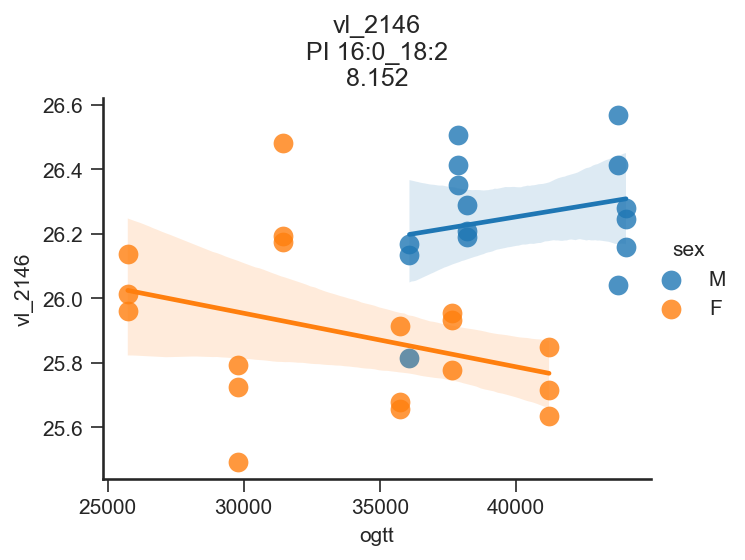

In [119]:
df = vldata.filter(regex='RBG').T.join(fg[['ogtt', 'sex']])
# feature = filt2.loc[filt2['is_id']].sample(1).index[0]  # random feature
feature = 'vl_2146' 
# fig, ax = plt.subplots(dpi=150, figsize=(5, 3))
sns.lmplot(
    data=df, 
#     y='vl_6435',
    y=feature,
    x='ogtt',
    hue='sex', 
    scatter_kws=dict(lw=0, s=90)
)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(5, 3)
fig.set_dpi(150)
ax.set_title(f'{feature}\n{vldata.loc[feature, "ID"]}\n{vldata.loc[feature, "RT"]}')

## Get a linear regression for 30wk M and 30wk F for each ID'd validation feature
## Compare slopes on scatterplot

In [69]:
df = vldata.loc[:, vldata_cols].T
df = df.join(fg[['ogtt', 'sex', 'animal']])
ols_models = []

for feature in df.filter(regex='vl_').columns:
    result = {'Feature': feature}
    for sex in ['F', 'M']:
        model = smf.ols(f'{feature} ~ ogtt', data=df.loc[df['sex'] == sex]).fit()
        result[sex+'_ogtt_slope'] = model.params['ogtt']
        result[sex+'_ogtt_slope_pval'] = model.pvalues['ogtt']
        result[sex+'_ogtt_slope_conf_int'] = model.conf_int().loc['ogtt'].to_list()
        result[sex+'_R2'] = model.rsquared
    ols_models.append(result)

In [72]:
rdf = pd.DataFrame(ols_models)
rdf.index = rdf['Feature']
rdf = rdf.join(vldata[['ID', 'molec_class', 'superclass', 'is_id']])
# rdf = rdf.loc[rdf['Lipid Class'].isin(colors.keys())]

rdf['M+F_R2'] = rdf['M_R2'] + rdf['F_R2']
rdf.sort_values('M+F_R2', ascending=False)[['M_R2', 'F_R2', 'ID', 'molec_class', 'superclass']]#.iloc[50:100]

,M_R2,F_R2,ID,molec_class,superclass
Feature,,,,,
vl_5993,0.393342,0.511039,Unidentified,Unidentified,Unidentified
vl_3992,0.684278,0.061065,Unidentified,Unidentified,Unidentified
vl_5202,0.646443,0.071210,Unidentified,Unidentified,Unidentified
vl_4373,0.674326,0.020292,Unidentified,Unidentified,Unidentified
vl_5204,0.644732,0.044544,Unidentified,Unidentified,Unidentified
...,...,...,...,...,...
vl_2998,0.002695,0.000504,PC 37:4,PC,Phospholipid
vl_2722,0.000453,0.001047,Unidentified,Unidentified,Unidentified
vl_2196,0.000296,0.001144,Unidentified,Unidentified,Unidentified


In [111]:
from decimal import Decimal
f"{Decimal('40800000000.00000'):.2E}"

'4.08E+10'

In [ ]:
def sci_power_4(x, pos):
    return f'{}'
plt.matplotlib.ticker.FuncFormatter()

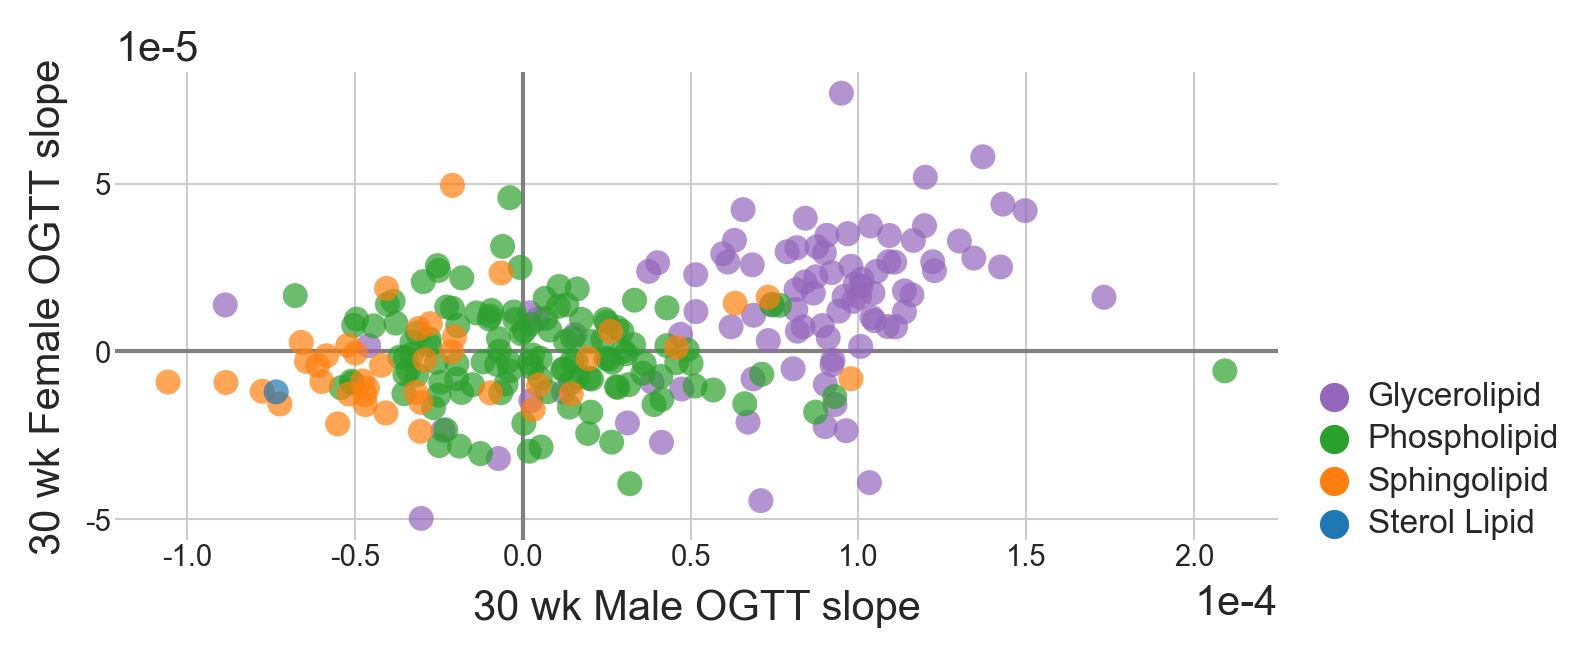

In [112]:
fig, ax = plt.subplots(dpi=300, figsize=(5, 5))

df = rdf.loc[rdf['ID'] != 'Unidentified']
df = df.sort_values('superclass')
sns.scatterplot(
    data=df, 
    y='F_ogtt_slope', x='M_ogtt_slope', hue='superclass', palette=colors,
    edgecolor='none', alpha=0.7, zorder=10,
)

## Label outliers 
# for i, row in df.iterrows():
#     if row['F_ogtt_slope'] > 0.00005 or row['F_ogtt_slope'] < -0.000038 or \
#         row['M_ogtt_slope'] > 0.00015 or row['M_ogtt_slope'] < -0.00008:
#         ax.text(row['M_ogtt_slope'], row['F_ogtt_slope'], row['ID'], 
#                 fontsize=5, ha='center', va='center')
        
ax.set_xlabel('30 wk Male OGTT slope')
ax.set_ylabel('30 wk Female OGTT slope')
ax.set_xticks([-10e-5, -5e-5, 0, 5e-5, 10e-5, 15e-5, 20e-5])
ax.set_yticks([-5e-5, 0, 5e-5])

ax.axvline(0, color='gray', lw=1, zorder=5)
ax.axhline(0, color='gray', lw=1, zorder=5)
ax.legend(loc=(1.01, 0))
ax.ticklabel_format(style='sci', scilimits=(0, 0), axis='both')
ax.tick_params(length=0, pad=1, labelsize=7)

ax.grid(lw=0.5)
ax.set_axisbelow(True)
ax.set_aspect('equal')
# set_square_ratio(ax)

ax.legend(loc=(1.02, 0), borderpad=0, labelspacing=0.34, frameon=False, handletextpad=0, fontsize=8)

sns.despine(bottom=True, left=True, ax=ax)

# plt.savefig('../reports/figures/Figure6/valdiation_ogtt_slope_vs_slope.pdf', bbox_inches='tight')

In [126]:
ap.filter(regex='^RBGweek')

,RBGweek4,RBGweek8,RBGweek9,RBGweek10,RBGweek11,RBGweek12,RBGweek20,RBGweek21,RBGweek22,RBGweek23,...,RBGweek25,RBGweek26,RBGweek27,RBGweek28,RBGweek29,RBGweek30,RBGweek31,RBGweek32,RBGweek33,RBGweek34
animal,,,,,,,,,,,,,,,,,,,,,
1060,71.0,225.000000,83.000000,206.0,221.000000,193.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1061,73.0,265.000000,289.500000,326.0,309.000000,370.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1062,78.0,256.500000,250.500000,139.5,248.500000,90.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1063,73.0,63.000000,46.500000,78.0,63.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1074,70.0,232.500000,203.500000,205.5,225.500000,139.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1075,69.0,383.000000,389.000000,367.0,514.000000,509.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1076,96.0,387.666667,281.000000,349.0,391.500000,435.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,57.0,117.333333,73.500000,45.0,61.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,79.0,297.333333,326.500000,321.5,384.500000,600.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
[x for x in data.columns]

['unique_id',
 'ID',
 'm/z',
 'RT',
 'molec_class',
 'Type',
 'polarity',
 'lc_type',
 'superclass',
 '1091_8_FBG',
 '1091_10_FBG',
 '1093_8_FBG',
 '1093_9_FBG',
 '1093_10_FBG',
 '1060_8_FBG',
 '1060_9_FBG',
 '1060_10_FBG',
 '1062_8_FBG',
 '1062_9_FBG',
 '1062_10_FBG',
 '1074_8_FBG',
 '1074_9_FBG',
 '1074_10_FBG',
 '1092_8_FBG',
 '1092_9_FBG',
 '1092_10_FBG',
 '1102_8_FBG',
 '1102_9_FBG',
 '1102_10_FBG',
 '1076_8_FBG',
 '1076_9_FBG',
 '1076_10_FBG',
 '1082_8_FBG',
 '1082_9_FBG',
 '1082_10_FBG',
 '1101_8_FBG',
 '1101_9_FBG',
 '1101_10_FBG',
 '1091_8_RBG',
 '1091_9_RBG',
 '1091_10_RBG',
 '1093_8_RBG',
 '1093_9_RBG',
 '1093_10_RBG',
 '1060_8_RBG',
 '1060_9_RBG',
 '1060_10_RBG',
 '1062_8_RBG',
 '1062_9_RBG',
 '1062_10_RBG',
 '1074_8_RBG',
 '1074_9_RBG',
 '1074_10_RBG',
 '1092_8_RBG',
 '1092_9_RBG',
 '1092_10_RBG',
 '1102_8_RBG',
 '1102_9_RBG',
 '1102_10_RBG',
 '1076_8_RBG',
 '1076_9_RBG',
 '1076_10_RBG',
 '1082_8_RBG',
 '1082_9_RBG',
 '1082_10_RBG',
 '1101_8_RBG',
 '1101_9_RBG',
 '1101_10_

In [95]:
data.loc[data['superclass'].str.contains('ingo'), ['coef_fed', 'coef_fasted', 'pval_fed', 'ID']]

,coef_fed,coef_fasted,pval_fed,ID
i,,,,
l_163,1.540970e-06,-6.143460e-06,6.297800e-01,SM d32:1
l_166,2.733269e-05,2.279024e-05,1.034582e-05,SM d40:7
l_177,5.391534e-06,1.692776e-06,1.241054e-01,SM d34:2
l_195,1.787285e-05,6.600415e-06,1.678907e-05,SM d36:3
l_208,5.102357e-06,2.342300e-06,7.696209e-02,SM d33:1
l_261,3.531137e-06,-1.221819e-06,3.541415e-01,SM d34:1
l_274,1.022664e-05,-1.208744e-06,9.192124e-03,SM d36:2
l_326,1.412913e-05,-5.948022e-07,2.568191e-04,SM d35:1
l_384,1.924501e-05,1.626027e-06,9.778777e-06,SM d36:1


## Despite looking messier in the validation data, the distribution of ID'd slopes for the fed regression lines is a bit wider than the IDs in the original data

<AxesSubplot:>

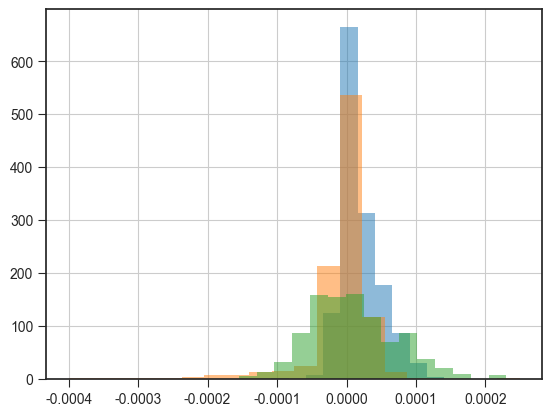

In [102]:
data['coef_fed'].hist(alpha=0.5)

rdf['F_ogtt_slope'].hist(alpha=0.5, bins=20)
rdf['M_ogtt_slope'].hist(alpha=0.5, bins=15)

In [78]:
top_m_r2 = (rdf
 .sort_values('M_R2', ascending=False)
 .loc[rdf['is_id'], ['M_R2', 'F_R2', 'ID', 'molec_class', 'superclass']]
 .iloc[:50]
)
top_m_r2

,M_R2,F_R2,ID,molec_class,superclass
Feature,,,,,
vl_4656,0.608790,0.003703,HexCer[NS] d42:1,HexCer[NS],Sphingolipid
vl_4657,0.599524,0.001432,GlcCer[NDS] d42:1,GlcCer[NDS],Sphingolipid
vl_4004,0.571311,0.034774,SM d41:2,SM,Sphingolipid
vl_2375,0.475723,0.032057,PC 18:2_20:4,PC,Phospholipid
vl_4609,0.475109,0.100519,Cer[NP] t18:0_23:0,Cer[NP],Sphingolipid
vl_2876,0.470899,0.014742,SM d34:0,SM,Sphingolipid
vl_3823,0.462429,0.094656,SM d40:2,SM,Sphingolipid
vl_4768,0.421942,0.077217,Cer[NP] t18:0_24:0,Cer[NP],Sphingolipid
vl_3013,0.391499,0.021269,Cer[NP] t18:0_16:0,Cer[NP],Sphingolipid


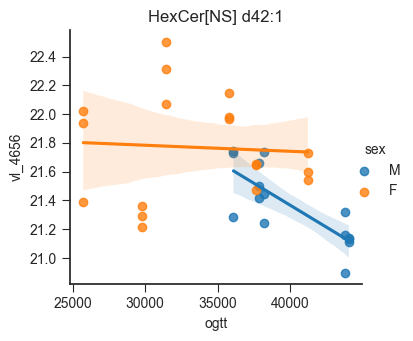

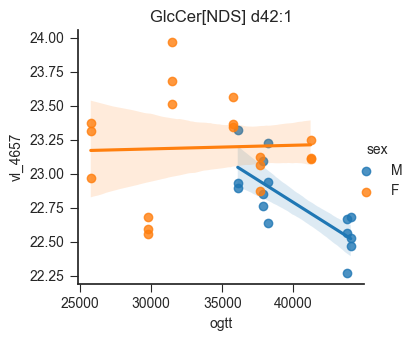

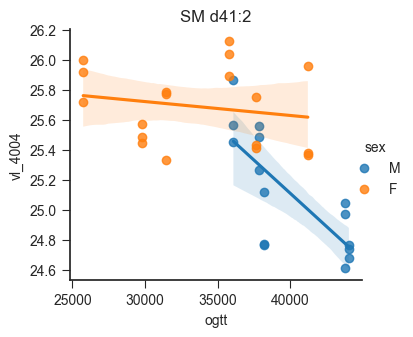

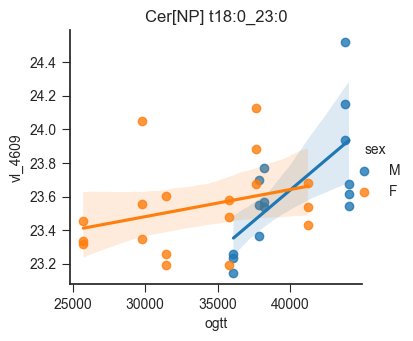

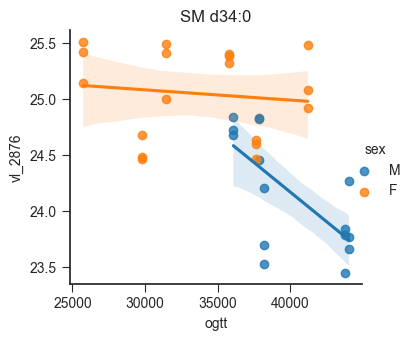

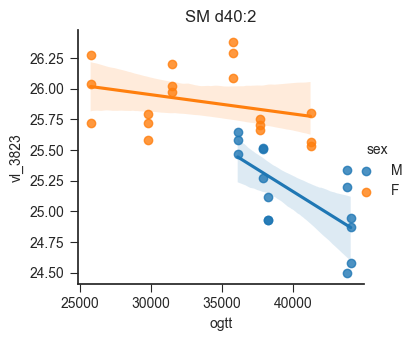

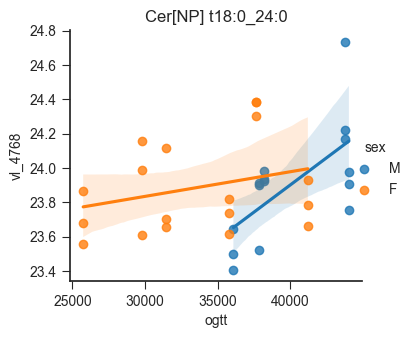

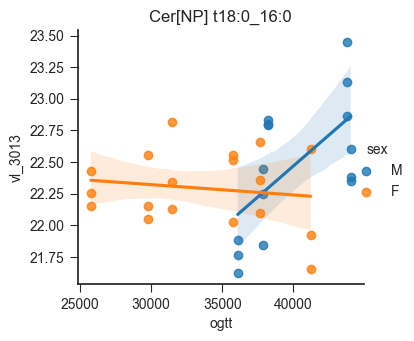

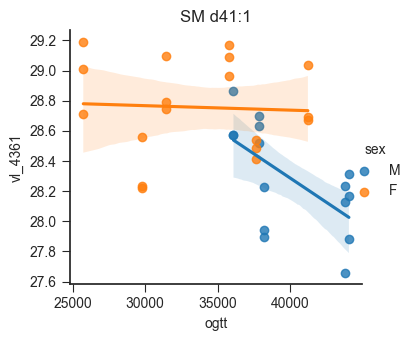

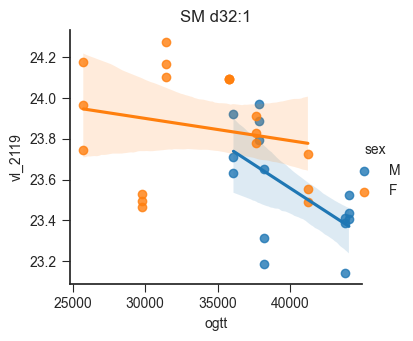

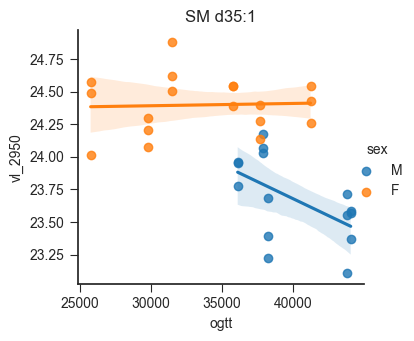

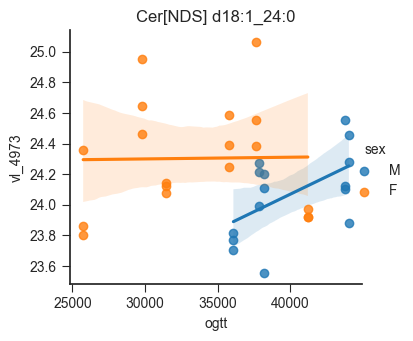

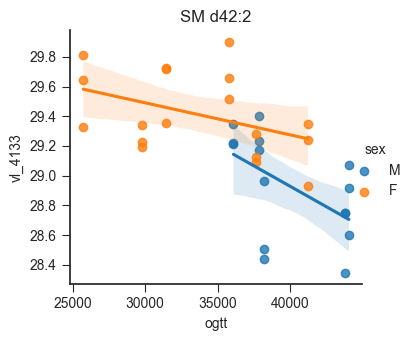

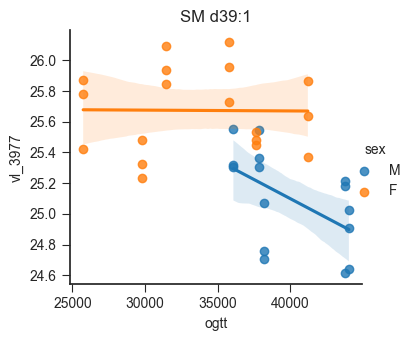

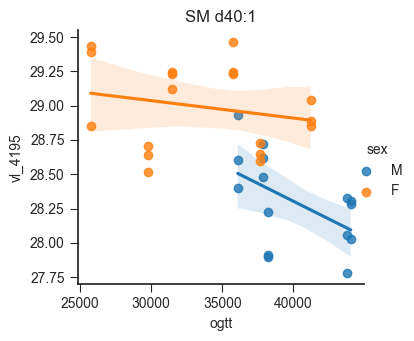

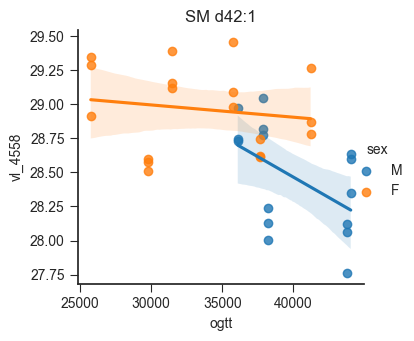

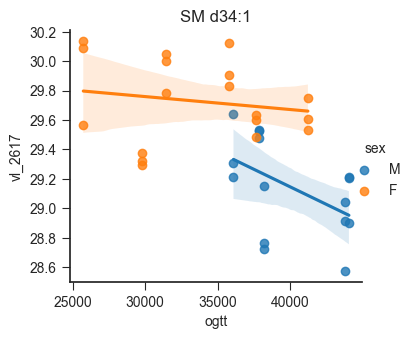

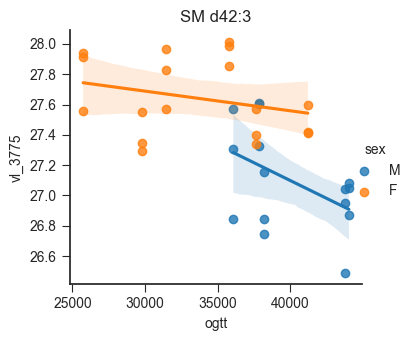

In [84]:
for i, row in top_m_r2.iterrows():
    if row['superclass'] != 'Sphingolipid':
        continue
    feat = i
    df = (vldata
          .loc[feat, vldata_cols]
          .astype('float')
          .to_frame()
          .join(fg[['ogtt', 'sex', 'num_wk_before_ogtt']])
         )
    # display(df)
    sns.lmplot(
        data=df, x='ogtt', y=feat, hue='sex', # col='num_wk_before_ogtt',
    )
    plt.gcf().set_size_inches(4, 3)
    plt.title(vldata.loc[feat, 'ID'])
    plt.savefig(f'../reports/figures/All Quant vs OGTT plots/validation sphingos/{i}.png', dpi=120, bbox_inches='tight')

In [ ]:
# animal_subset = ap.loc[(ap['validation'])].index
# df = fr.loc[:, fg.loc[(fg['animal'].isin(animal_subset)) & (fg['validation'])].index]
# # df = df.join(fr['Identification'])

# top_feat_ids = [
#     'CE 18:1', 
#     'Plasmanyl-PC O-20:0_20:4', 
#     'FA 18:0',
#     'PC 36:3', 'PC 38:7', 
#     '4-Guanidinobutyric acid', 
#     'SM d37:1',
#     'TG 20:5_22:6_22:6', 'TG 22:6_22:6_22:6', 'TG 18:1_22:6_22:6',
# ]
# # df = df.loc[fr['Identification'].isin(top_feat_ids)]
# df = df.T
# df = df.join(fg[['ogtt', 'sex', 'animal', 'cohort']])
# df['ogtt']
# df.columns = df.columns.astype('str')
# df['group'] = df['cohort'] + '_' + df['sex']
# # df = df.drop(fg.loc[~fg['sufficient_sample']].index)
# display(df.columns)
# df = df.loc[(df['group'].isin([
# #     '10wk_M', 
#     '30wk_M', 
#     '30wk_F'
# ]))]

for tg in filt.index: 
    feature = str(tg)
    # fig, ax = plt.subplots(dpi=300, figsize=(4, 3))
    sns.lmplot(
        data=df, y=feature, x='ogtt',
        hue='group', 
        scatter_kws=dict(lw=0, s=90)
    )
    fig = plt.gcf()
    fig.set_dpi(150)
    fig.set_size_inches(5, 3)
    fig.set_facecolor('white')
    plt.title(fr.loc[int(feature), 'Identification'])
#     plt.savefig(f'../reports/figures/All Quant vs OGTT plots/validation ogtt/{feature}.png', 
#                 dpi=120, facecolor='white', bbox_inches='tight')
    # fig.legend(loc=(1, 0))
    # for animal in animal_subset:
    #     if apval.loc[animal, 'sex'] == 'F':
    #         plt.axvline(apval.loc[animal, 'OGTT(AUC)'], color='0.1', lw=0.5)